In [107]:
import openeo
from matplotlib import pyplot as plt
import rasterio.plot
import io
import tarfile
import numpy as np
import glob
import re
import os
import xarray as xr
import torch
import functions.handy_functions as hf

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

In [108]:
main_dir='/cloud/skogsstyrelsen_pairs/'
directories=os.listdir(main_dir)
#directories

In [109]:
from cot_train.utils import StatCollector, MLP5, mlp_inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [110]:
model_load_paths=['cot_model/0/model_it_2000000','cot_model/1/model_it_2000000',
                  'cot_model/2/model_it_2000000','cot_model/3/model_it_2000000',
                  'cot_model/4/model_it_2000000']

input_dim = 13
output_dim = 1

models_cot=[]
for model_path in model_load_paths:
    model_cot = MLP5(input_dim, output_dim, apply_relu=True)
    model_cot.load_state_dict(torch.load(model_path, map_location=device))
    model_cot.to(device)
    models_cot.append(model_cot)

means=[0.534958,0.538317,0.532992,0.629737,0.826885,0.859306,0.803385,0.880321,0.408178,0.066565,0.428241,0.301306,58.076266]
stds=[0.218962,0.188747,0.236514,0.185751,0.169492,0.170012,0.162448,0.171793,0.237684,0.096908,0.309903,0.202586,15.602082]

In [111]:
ims_all=[]
temporals_all=[]
for dir in directories:
    data_clear=xr.load_dataset(main_dir+dir+'/clear_data.nc', engine='netcdf4', decode_times=True)
    data_cloudy=xr.load_dataset(main_dir+dir+'/cloudy_data.nc', engine='netcdf4', decode_times=True)

    variables=data_clear.variables

    ## Get bands ##
    b02=variables['b02'].data
    b03=variables['b03'].data
    b04=variables['b04'].data
    b05=variables['b05'].data
    b06=variables['b06'].data
    b07=variables['b07'].data
    b08=variables['b08'].data
    b8a=variables['b8a'].data
    b09=variables['b09'].data
    b10=variables['b10'].data
    b11=variables['b11'].data
    b12=variables['b12'].data
    sun_z=variables['sun_zenith_angle'].data
    c_mask=variables['cloud_mask'].data

    ## Save image ##
    im_clear=np.zeros((np.shape(b03)[0],np.shape(b03)[1],14))
    im_clear[:,:,0]=b02
    im_clear[:,:,1]=b03
    im_clear[:,:,2]=b04
    im_clear[:,:,3]=b05
    im_clear[:,:,4]=b06
    im_clear[:,:,5]=b07
    im_clear[:,:,6]=b08
    im_clear[:,:,7]=b8a
    im_clear[:,:,8]=b09
    im_clear[:,:,9]=b10
    im_clear[:,:,10]=b11
    im_clear[:,:,11]=b12
    im_clear[:,:,12]=sun_z
    im_clear[:,:,13]=c_mask

    variables=data_cloudy.variables

    ## Get bands ##
    b02=variables['b02'].data
    b03=variables['b03'].data
    b04=variables['b04'].data
    b05=variables['b05'].data
    b06=variables['b06'].data
    b07=variables['b07'].data
    b08=variables['b08'].data
    b8a=variables['b8a'].data
    b09=variables['b09'].data
    b10=variables['b10'].data
    b11=variables['b11'].data
    b12=variables['b12'].data
    sun_z=variables['sun_zenith_angle'].data
    cot=variables['cloud_mask'].data

    ## Save image ##
    im_cloudy=np.zeros((np.shape(b03)[0],np.shape(b03)[1],14))
    im_cloudy[:,:,0]=b02
    im_cloudy[:,:,1]=b03
    im_cloudy[:,:,2]=b04
    im_cloudy[:,:,3]=b05
    im_cloudy[:,:,4]=b06
    im_cloudy[:,:,5]=b07
    im_cloudy[:,:,6]=b08
    im_cloudy[:,:,7]=b8a
    im_cloudy[:,:,8]=b09
    im_cloudy[:,:,9]=b10
    im_cloudy[:,:,10]=b11
    im_cloudy[:,:,11]=b12
    im_cloudy[:,:,12]=sun_z
    im_cloudy[:,:,13]=cot

    #Reshape and prepare COT estimation
    im_shape=np.shape(im_cloudy)
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
    for i in range(im_shape[2]):
        im_cloud_r[:,i]=np.reshape(im_cloudy[:,:,i],im_shape[0]*im_shape[1])

    #COT estimation
    inputs = (im_cloud_r[:,:13] - means) / stds
    image_input_tens=torch.Tensor(inputs).to(device)
    #image_pred_cot=model_cot(image_input_tens).cpu().data.numpy()*50
    preds = 0
    for model_cot in models_cot:
        curr_preds=model_cot(image_input_tens)/len(models_cot)
        preds=preds+curr_preds
    pred_cot=preds.cpu().data.numpy()*50 #unnormalise
    pred_cot=np.reshape(pred_cot,(im_shape[0],im_shape[1]))

    t_is_cloud = 0.025*50 # From Alex
    t_thin_cloud = 0.015*50 # From Alex
    im_shape=np.shape(im_cloudy)
    c_mask=pred_cot.copy()
    c_mask=np.reshape(c_mask,im_shape[0]*im_shape[1])
    c_mask[c_mask<t_thin_cloud]=0
    c_mask[(c_mask>t_thin_cloud)&(c_mask<t_is_cloud)]=1
    c_mask[c_mask>t_is_cloud]=2
    c_mask=np.reshape(c_mask,(im_shape[0],im_shape[1]))

    im_cloudy_cmask=np.zeros((im_shape[0],im_shape[1],im_shape[2]+1))
    im_cloudy_cmask[:,:,0:14]=im_cloudy
    im_cloudy_cmask[:,:,13]=pred_cot
    im_cloudy_cmask[:,:,-1]=c_mask

    im_pair=[im_clear,im_cloudy_cmask]
    ims_all.append(im_pair)
    temporals_all.append([data_clear.coords['t'].data[0],data_cloudy.coords['t'].data[0]])

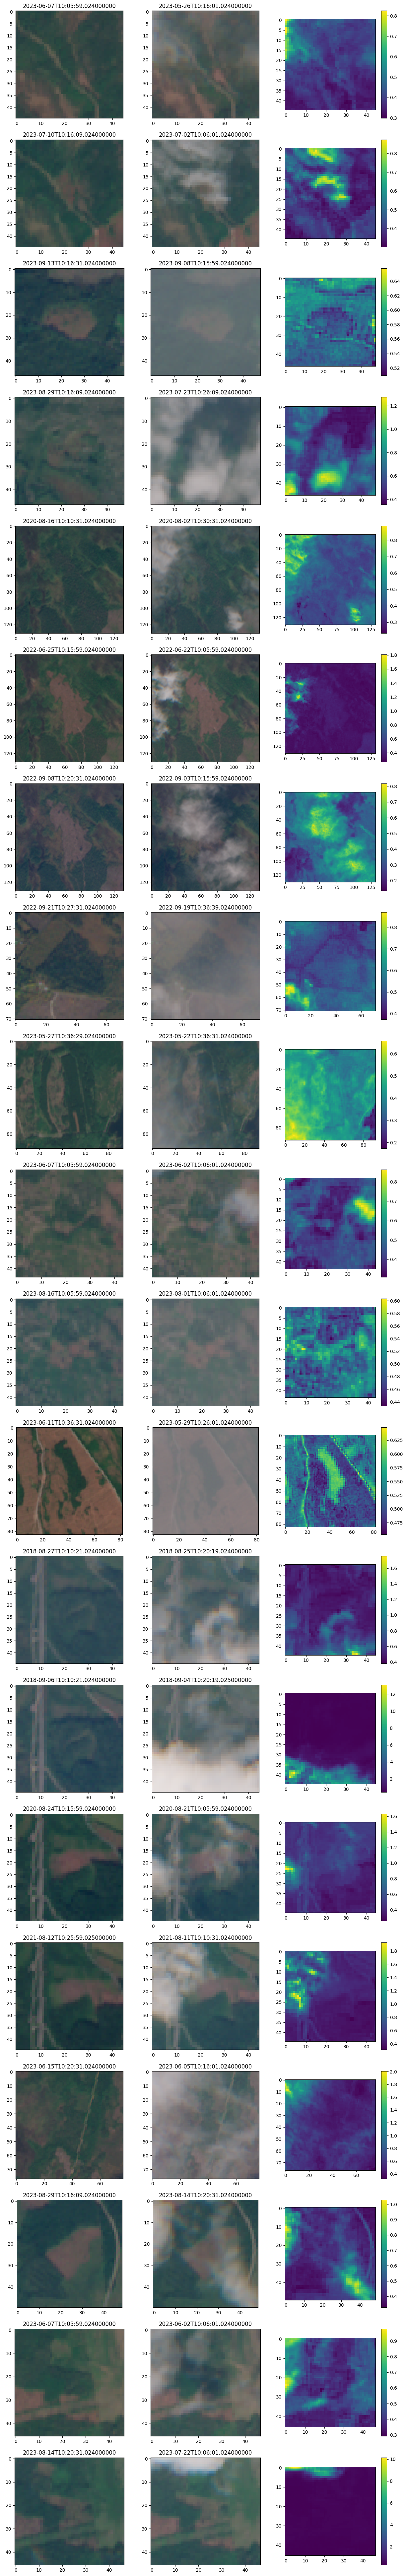

In [112]:
ncols=3
nrows=len(ims_all)

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,pair in enumerate(ims_all):

    im_clear=pair[0]
    im_cloud=pair[1]

    im_clear_show=hf.Sentinel2TrueColor(im_clear)
    im_cloud_show=hf.Sentinel2TrueColor(im_cloud)

    axs[pair_c,0].imshow(im_clear_show)
    axs[pair_c,0].set_title(temporals_all[i][0])
    axs[pair_c,1].imshow(im_cloud_show)
    axs[pair_c,1].set_title(temporals_all[i][1])
    im_c=axs[pair_c,2].imshow(im_cloud[:,:,-2])
    fig.colorbar(im_c,ax=axs[pair_c,2])
    pair_c+=1

In [113]:
main_filepath='pytorch_models/COT_anton_old_data_trans'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))
    
index_median=1

In [114]:
preds_all=[]
uncertainties_all=[]
for i,pair in enumerate(ims_all):
    im_cloud=pair[1]

    ## Reshape cloudy data
    im_shape=np.shape(im_cloud)
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
    for i in range(im_shape[2]):
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    im_pred_cot_t_r=im_cloud_r[:,-1]
    #One hot encode cot
    cot_one_hot=np.zeros((len(im_pred_cot_t_r),3))
    cot_one_hot[im_pred_cot_t_r==0,0]=1
    cot_one_hot[im_pred_cot_t_r==1,1]=1
    cot_one_hot[im_pred_cot_t_r==2,2]=1

    ## append cot estimation to input data ##
    im_cloud_r_c=np.zeros((np.shape(im_cloud_r)[0],np.shape(im_cloud_r)[1]+3))
    im_cloud_r_c[:,0:14]=im_cloud_r[:,0:14]
    im_cloud_r_c[:,15:19]=cot_one_hot

    ## Make prediction
    for i,model in enumerate(models):
        if i==0:
            pred=model.predict(im_cloud_r_c[:,0:14])
        else:   
            pred=pred+model.predict(im_cloud_r_c[:,0:14])
    pred=pred/len(models)

    ##Reshape back
    im_shape_pred=(im_shape[0],im_shape[1],12)
    im_pred=np.zeros(im_shape_pred)
    im_unc=np.zeros(im_shape_pred)
    for i in range(im_shape_pred[2]):
        im_pred[:,:,i]=np.reshape(pred[:,i,index_median],im_shape_pred[0:2])
        im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape_pred[0:2])

    preds_all.append(im_pred)
    uncertainties_all.append(im_unc)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


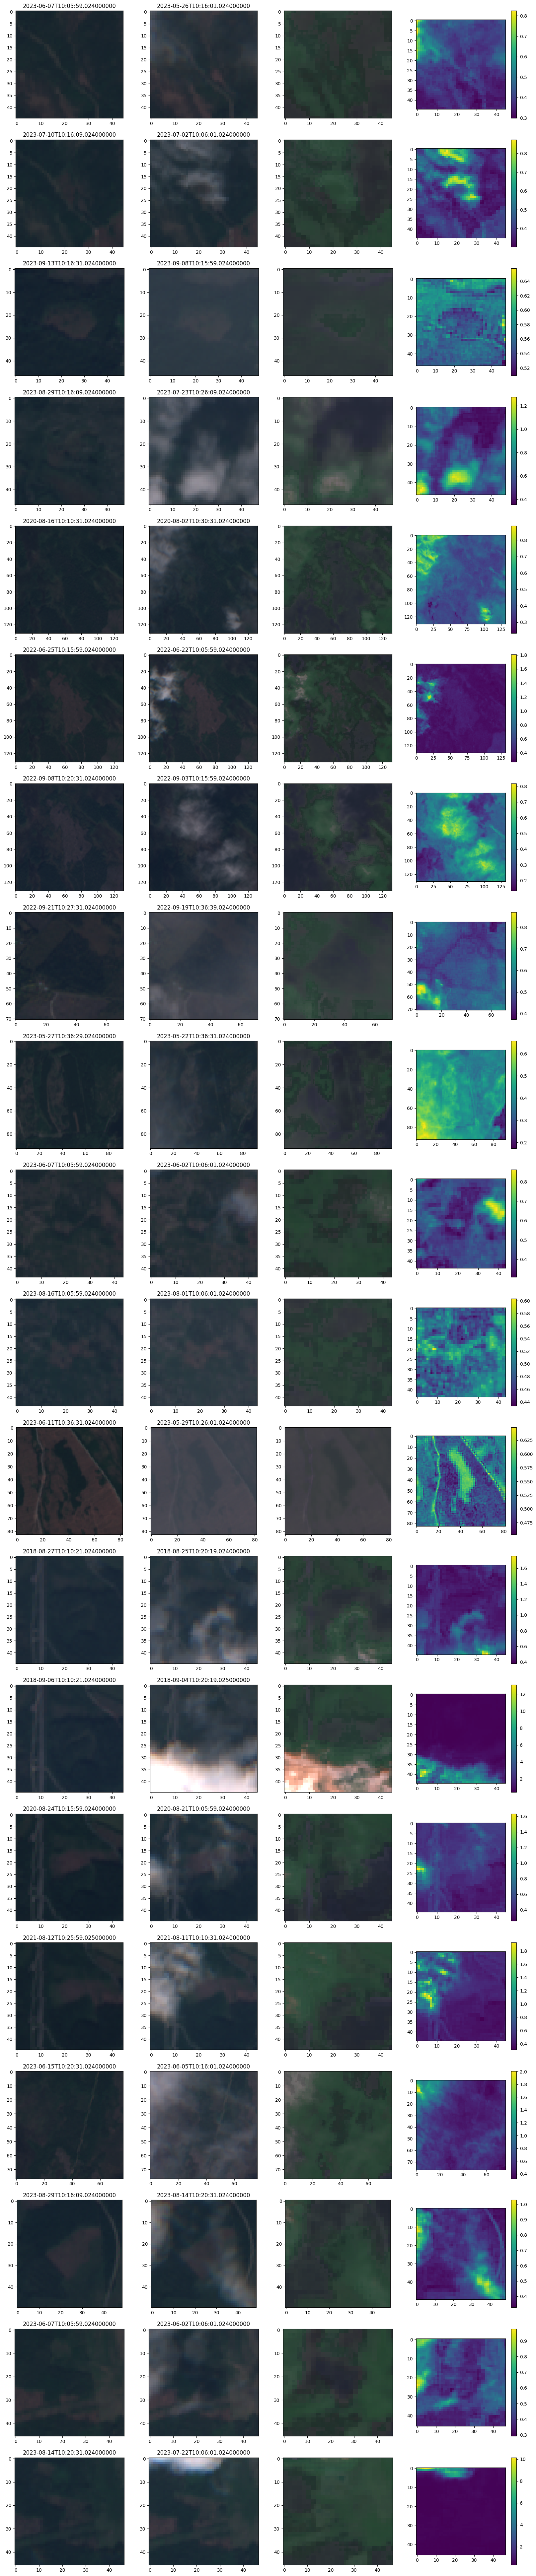

In [115]:
ncols=4
nrows=len(ims_all)

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,pair in enumerate(ims_all):

    im_clear=pair[0]
    im_cloud=pair[1]

    axs[pair_c,0].imshow(np.flip(im_clear[:,:,0:3],axis=2)*2)
    axs[pair_c,0].set_title(temporals_all[i][0])
    axs[pair_c,1].imshow(np.flip(im_cloud[:,:,0:3],axis=2)*2)
    axs[pair_c,1].set_title(temporals_all[i][1])
    axs[pair_c,2].imshow(np.flip(preds_all[i][:,:,0:3],axis=2)*2)
    im_c=axs[pair_c,3].imshow(im_cloud[:,:,-2])
    fig.colorbar(im_c,ax=axs[pair_c,3])
    pair_c+=1

## Evaluate predictions

In [116]:
n_pairs=len(preds_all)

NMSEs_og=np.zeros((n_pairs,12))
NMSEs_pred=np.zeros((n_pairs,12))

p_c=0
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]

    #np.linal.norm() -> Frobenius norm i.e root of the sum of squares
    norm_og=np.linalg.norm((im_clear[:,:,0:12])-(im_cloud[:,:,0:12]),axis=(0,1))**2
    norm_pred=np.linalg.norm((im_clear[:,:,0:12])-im_pred[:,:,0:12],axis=(0,1))**2
    norm_gt=np.linalg.norm(im_clear[:,:,0:12],axis=(0,1))**2

    NMSE_og=norm_og/norm_gt
    NMSE_pred=norm_pred/norm_gt

    NMSEs_og[p_c,:]=NMSE_og
    NMSEs_pred[p_c,:]=NMSE_pred
    p_c+=1

mean_NMSE_og=np.mean(NMSEs_og,axis=0)
mean_NMSE_pred=np.mean(NMSEs_pred,axis=0)

mean_NMSE_og_wo_10=np.concatenate((mean_NMSE_og[0:9],mean_NMSE_og[10:]),axis=0)
mean_NMSE_pred_wo_10=np.concatenate((mean_NMSE_pred[0:9],mean_NMSE_pred[10:]),axis=0)

In [117]:
mean_NMSE_og_wo_10

array([0.41693819, 0.63111419, 1.53128664, 0.7111659 , 0.18071384,
       0.14165939, 0.1327339 , 0.12306208, 0.60155005, 0.37297669,
       1.22581311])

In [118]:
for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(mean_NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(mean_NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(mean_NMSE_pred[i]))    

    print(' ')

print('Mean NMSE before correction: '+str(np.mean(mean_NMSE_og)))
print('Mean NMSE after correction: '+str(np.mean(mean_NMSE_pred)))    

print(' ')

print('Mean NMSE before correction, without band 10: '+str(np.mean(mean_NMSE_og_wo_10)))
print('Mean NMSE after correction, without band 10: '+str(np.mean(mean_NMSE_pred_wo_10)))    

NMSE before correction, Band 2: 0.4169381874332044
NMSE after correction, Band 2: 0.08978314342275148
 
NMSE before correction, Band 3: 0.6311141936187977
NMSE after correction, Band 3: 0.36107147754242164
 
NMSE before correction, Band 4: 1.5312866439842163
NMSE after correction, Band 4: 0.7744838286053891
 
NMSE before correction, Band 5: 0.7111659042342112
NMSE after correction, Band 5: 0.6152102412617729
 
NMSE before correction, Band 6: 0.1807138430257292
NMSE after correction, Band 6: 0.21249031240552405
 
NMSE before correction, Band 7: 0.14165939185500012
NMSE after correction, Band 7: 0.1573091330814193
 
NMSE before correction, Band 8: 0.13273390358159842
NMSE after correction, Band 8: 0.1473053823683944
 
NMSE before correction, Band 8A: 0.12306208197048837
NMSE after correction, Band 8A: 0.10650030595159268
 
NMSE before correction, Band 9: 0.601550049057272
NMSE after correction, Band 9: 0.5955597831295172
 
NMSE before correction, Band 10: 1.9097379940077555
NMSE after co

### Percent from ground truth

In [119]:
in_og=np.zeros((n_pairs,12))
in_pred=np.zeros((n_pairs,12))
p_c=0
percent=0.2
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]
    for k in range(12):
        im_pred_b=im_pred[:,:,k]
        im_cloud_b=im_cloud[:,:,k]
        im_truth_b=im_clear[:,:,k]


        im_in_percent=np.abs(im_pred_b-im_truth_b) <= percent*im_truth_b
        im_in_percent_c=np.abs(im_cloud_b-im_truth_b) <= percent*im_truth_b

        in_og[p_c,k]=np.sum(im_in_percent_c)/np.size(im_in_percent_c)
        in_pred[p_c,k]=np.sum(im_in_percent)/np.size(im_in_percent)

    p_c+=1

mean_in_og=np.mean(in_og,axis=0)
mean_in_pred=np.mean(in_pred,axis=0)

In [120]:
print('Percent pixels within '+str(percent*100)+' percent from ground truth')
print(' ')
for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('OG, Band ' +str(i+2)+': '+str(mean_in_og[i]))
        print('Pred, Band '+str(i+2)+': '+str(mean_in_pred[i]))
    elif i==7:
        print('OG, Band '+str(i+1)+'A: '+str(mean_in_og[i]))
        print('Pred, Band '+str(i+1)+'A: '+str(mean_in_pred[i]))
    else:
        print('OG, Band '+str(i+1)+': '+str(mean_in_og[i]))
        print('Pred, Band '+str(i+1)+': '+str(mean_in_pred[i]))    

    print(' ')

Percent pixels within 20.0 percent from ground truth
 
OG, Band 2: 0.4081931471568076
Pred, Band 2: 0.6002419390291581
 
OG, Band 3: 0.35892053979160676
Pred, Band 3: 0.11802523635071756
 
OG, Band 4: 0.25854440291860636
Pred, Band 4: 0.21703967184945966
 
OG, Band 5: 0.30552160688187896
Pred, Band 5: 0.09252566071549624
 
OG, Band 6: 0.5013449383870513
Pred, Band 6: 0.26511285120330835
 
OG, Band 7: 0.5384945053151526
Pred, Band 7: 0.3606192707332829
 
OG, Band 8: 0.5387446409529942
Pred, Band 8: 0.4122286596418693
 
OG, Band 8A: 0.56626353531654
Pred, Band 8A: 0.5400140068229606
 
OG, Band 9: 0.3282025386151713
Pred, Band 9: 0.25480512119972826
 
OG, Band 10: 0.22625498022114404
Pred, Band 10: 0.2286316780964459
 
OG, Band 11: 0.40761860832029057
Pred, Band 11: 0.06610479471522211
 
OG, Band 12: 0.31070877116975015
Pred, Band 12: 0.04339288075603217
 


In [121]:
abs_distances_og=np.zeros((n_pairs,12))
abs_distances_pred=np.zeros((n_pairs,12))

p_c=0
percent=0.2
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]

    for k in range(12):
        im_pred_b=im_pred[:,:,k]
        im_cloud_b=im_cloud[:,:,k]
        im_truth_b=im_clear[:,:,k]

        abs_dist_pred=np.abs(im_pred_b-im_truth_b)
        abs_dist_og=np.abs(im_cloud_b-im_truth_b)

        abs_distances_og[p_c,k]=np.mean(abs_dist_og)
        abs_distances_pred[p_c,k]=np.mean(abs_dist_pred)

    p_c+=1

mean_dist_og=np.mean(abs_distances_og,axis=0)
mean_dist_pred=np.mean(abs_distances_pred,axis=0)

In [122]:
print('Mean Absolute distance to ground truth: ')
print(' ')
for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('OG, Band ' +str(i+2)+': '+str(mean_dist_og[i]))
        print('Pred, Band '+str(i+2)+': '+str(mean_dist_pred[i]))
    elif i==7:
        print('OG, Band '+str(i+1)+'A: '+str(mean_dist_og[i]))
        print('Pred, Band '+str(i+1)+'A: '+str(mean_dist_pred[i]))
    else:
        print('OG, Band '+str(i+1)+': '+str(mean_dist_og[i]))
        print('Pred, Band '+str(i+1)+': '+str(mean_dist_pred[i]))    

    print(' ')

Mean Absolute distance to ground truth: 
 
OG, Band 2: 0.039553311771668126
Pred, Band 2: 0.019072132075509167
 
OG, Band 3: 0.038340792878423104
Pred, Band 3: 0.03869252300554983
 
OG, Band 4: 0.04234902506958027
Pred, Band 4: 0.03501986911761054
 
OG, Band 5: 0.044386102345869025
Pred, Band 5: 0.055722940207998214
 
OG, Band 6: 0.049950597702947644
Pred, Band 6: 0.06637322878511183
 
OG, Band 7: 0.0538085934760296
Pred, Band 7: 0.06614726592197784
 
OG, Band 8: 0.052473310660033454
Pred, Band 8: 0.061646498700905474
 
OG, Band 8A: 0.057007767415921354
Pred, Band 8A: 0.05679896257561812
 
OG, Band 9: 0.031317953710342454
Pred, Band 9: 0.03483320671817728
 
OG, Band 10: 0.001264988880761401
Pred, Band 10: 0.0008390048994485578
 
OG, Band 11: 0.05070842412598646
Pred, Band 11: 0.15194134177019364
 
OG, Band 12: 0.041946386709226346
Pred, Band 12: 0.12029595175752439
 


In [123]:
clear_array=np.zeros((1,12))
pred_array=np.zeros((1,12))
cloud_array=np.zeros((1,14))
unc_array=np.zeros((1,12))
cloud_mask_array=np.zeros((1))
p_c=0
percent=0.2
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]
    im_unc=uncertainties_all[i]

    im_shape=np.shape(im_pred)
    c_mask=im_cloud[:,:,-1]
    c_mask_r=np.reshape(c_mask,im_shape[0]*im_shape[1])


    im_pred_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    im_clear_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]+2)) #+1 for sun zenith angle
    im_unc_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))

    for i in range(im_shape[2]):
        im_pred_r[:,i]=np.reshape(im_pred[:,:,i],im_shape[0]*im_shape[1])
        im_clear_r[:,i]=np.reshape(im_clear[:,:,i],im_shape[0]*im_shape[1])
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])
        im_unc_r[:,i]=np.reshape(im_unc[:,:,i],im_shape[0]*im_shape[1])

    im_cloud_r[:,12]=np.reshape(im_cloud[:,:,12],im_shape[0]*im_shape[1])
    im_cloud_r[:,13]=np.reshape(im_cloud[:,:,13],im_shape[0]*im_shape[1])

    clear_array=np.concatenate((clear_array,im_clear_r[:,0:12]))
    pred_array=np.concatenate((pred_array,im_pred_r))
    cloud_array=np.concatenate((cloud_array,im_cloud_r))
    unc_array=np.concatenate((unc_array,im_unc_r))
    cloud_mask_array=np.concatenate((cloud_mask_array,c_mask_r))

    p_c+=1


In [124]:
band=10

Text(0.5, 1.0, 'Ground truth and prediction, B11')

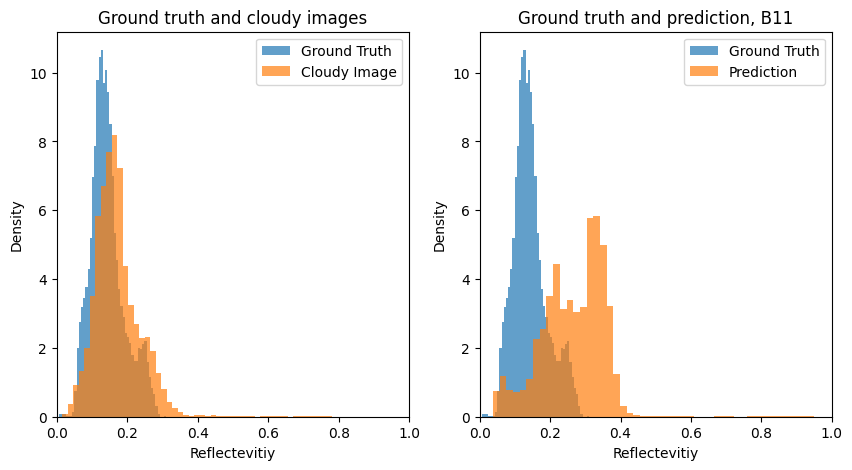

In [125]:
plt.rcParams['figure.figsize'] = [10, 5]
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0]


axs[0].hist(clear_array[:,band],alpha=0.7,bins=50,density=True)
axs[0].hist(cloud_array[:,band],alpha=0.7,bins=50,density=True)
axs[0].set_xlim([0,1])
axs[0].legend(['Ground Truth','Cloudy Image'])
axs[0].set_xlabel('Reflectevitiy')
axs[0].set_ylabel('Density')
axs[0].set_title('Ground truth and cloudy images')

axs[1].hist(clear_array[:,band],alpha=0.7,bins=50,density=True)
axs[1].hist(pred_array[:,band],alpha=0.7,bins=50,density=True)
axs[1].set_xlim([0,1])
axs[1].legend(['Ground Truth','Prediction'])
axs[1].set_xlabel('Reflectevitiy')
axs[1].set_ylabel('Density')
axs[1].set_title('Ground truth and prediction, B11')

#fig.suptitle('Histogram of pixel reflectivity of ground truth, cloudy images and predictions, B11')

In [126]:
clear_array_c=np.zeros((1,12))
pred_array_c=np.zeros((1,12))
cloud_array_c=np.zeros((1,12))
p_c=0
percent=0.2
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]

    im_shape=np.shape(im_pred)

    cloud_mask=im_cloud[:,:,-1]
    cloud_mask_r=np.reshape(cloud_mask,im_shape[0]*im_shape[1])
    cloud_mask_r=cloud_mask_r>0

    im_pred_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    im_clear_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    for i in range(im_shape[2]):
        im_pred_r[:,i]=np.reshape(im_pred[:,:,i],im_shape[0]*im_shape[1])
        im_clear_r[:,i]=np.reshape(im_clear[:,:,i],im_shape[0]*im_shape[1])
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    im_pred_r=im_pred_r[cloud_mask_r,:]
    im_clear_r=im_clear_r[cloud_mask_r,:]
    im_cloud_r=im_cloud_r[cloud_mask_r,:]


    clear_array_c=np.concatenate((clear_array_c,im_clear_r[:,0:12]))
    pred_array_c=np.concatenate((pred_array_c,im_pred_r))
    cloud_array_c=np.concatenate((cloud_array_c,im_cloud_r))

    p_c+=1

Text(0.5, 0.98, 'Same histogram only cloudy pixels, B11')

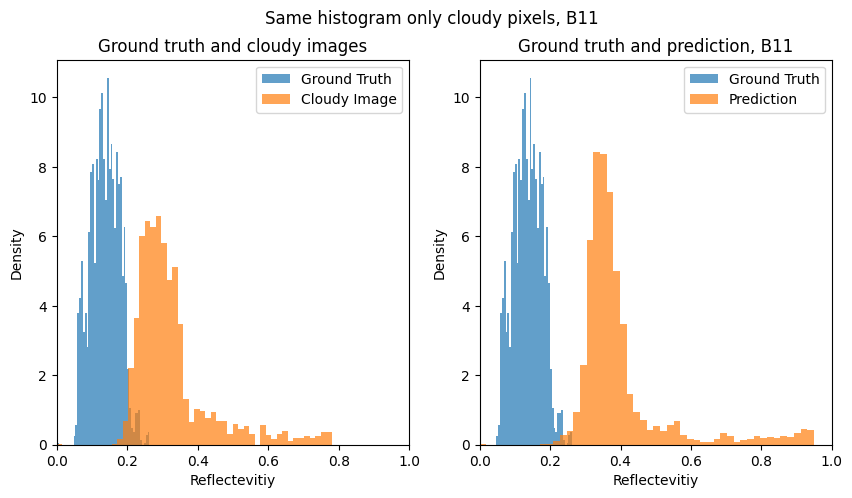

In [127]:
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0]

plt.rcParams['figure.figsize'] = [10, 5]
axs[0].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].hist(cloud_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].set_xlim([0,1])
axs[0].legend(['Ground Truth','Cloudy Image'])
axs[0].set_xlabel('Reflectevitiy')
axs[0].set_ylabel('Density')
axs[0].set_title('Ground truth and cloudy images')

axs[1].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].hist(pred_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].set_xlim([0,1])
axs[1].legend(['Ground Truth','Prediction'])
axs[1].set_xlabel('Reflectevitiy')
axs[1].set_ylabel('Density')
axs[1].set_title('Ground truth and prediction, B11')

fig.suptitle('Same histogram only cloudy pixels, B11')

In [128]:
clear_array_c=np.zeros((1,12))
pred_array_c=np.zeros((1,12))
cloud_array_c=np.zeros((1,12))
p_c=0
percent=0.2
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]

    im_shape=np.shape(im_pred)

    cloud_mask=im_cloud[:,:,-1]
    cloud_mask_r=np.reshape(cloud_mask,im_shape[0]*im_shape[1])
    cloud_mask_r=cloud_mask_r==0

    im_pred_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    im_clear_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    for i in range(im_shape[2]):
        im_pred_r[:,i]=np.reshape(im_pred[:,:,i],im_shape[0]*im_shape[1])
        im_clear_r[:,i]=np.reshape(im_clear[:,:,i],im_shape[0]*im_shape[1])
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    im_pred_r=im_pred_r[cloud_mask_r,:]
    im_clear_r=im_clear_r[cloud_mask_r,:]
    im_cloud_r=im_cloud_r[cloud_mask_r,:]


    clear_array_c=np.concatenate((clear_array_c,im_clear_r[:,0:12]))
    pred_array_c=np.concatenate((pred_array_c,im_pred_r))
    cloud_array_c=np.concatenate((cloud_array_c,im_cloud_r))

    p_c+=1

Text(0.5, 0.98, 'Same histogram only clear pixels, B11')

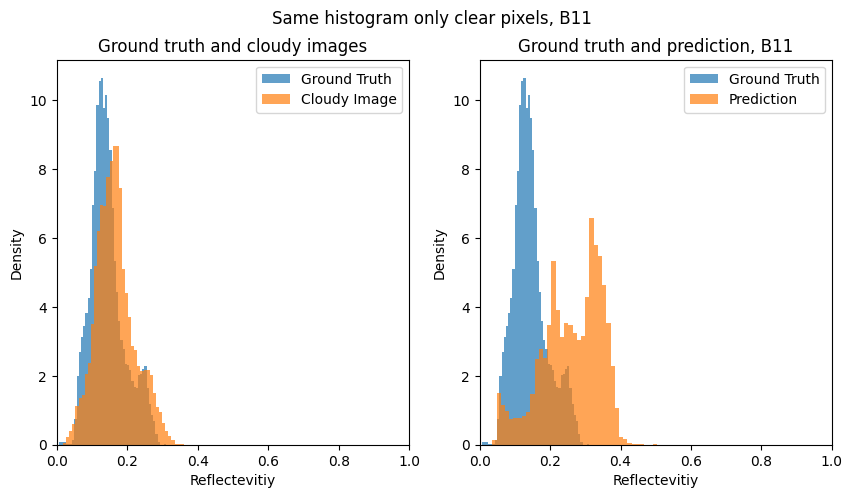

In [129]:
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0]

plt.rcParams['figure.figsize'] = [10, 5]
axs[0].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].hist(cloud_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].set_xlim([0,1])
axs[0].legend(['Ground Truth','Cloudy Image'])
axs[0].set_xlabel('Reflectevitiy')
axs[0].set_ylabel('Density')
axs[0].set_title('Ground truth and cloudy images')

axs[1].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].hist(pred_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].set_xlim([0,1])
axs[1].legend(['Ground Truth','Prediction'])
axs[1].set_xlabel('Reflectevitiy')
axs[1].set_ylabel('Density')
axs[1].set_title('Ground truth and prediction, B11')

fig.suptitle('Same histogram only clear pixels, B11')

In [130]:
clear_array_c=np.zeros((1,12))
pred_array_c=np.zeros((1,12))
cloud_array_c=np.zeros((1,12))
p_c=0
percent=0.2
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]

    im_shape=np.shape(im_pred)

    cloud_mask=im_cloud[:,:,-1]
    cloud_mask_r=np.reshape(cloud_mask,im_shape[0]*im_shape[1])
    cloud_mask_r=cloud_mask_r==1

    im_pred_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    im_clear_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    for i in range(im_shape[2]):
        im_pred_r[:,i]=np.reshape(im_pred[:,:,i],im_shape[0]*im_shape[1])
        im_clear_r[:,i]=np.reshape(im_clear[:,:,i],im_shape[0]*im_shape[1])
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    im_pred_r=im_pred_r[cloud_mask_r,:]
    im_clear_r=im_clear_r[cloud_mask_r,:]
    im_cloud_r=im_cloud_r[cloud_mask_r,:]


    clear_array_c=np.concatenate((clear_array_c,im_clear_r[:,0:12]))
    pred_array_c=np.concatenate((pred_array_c,im_pred_r))
    cloud_array_c=np.concatenate((cloud_array_c,im_cloud_r))

    p_c+=1

Text(0.5, 0.98, 'Same histogram only thin cloud pixels, B11')

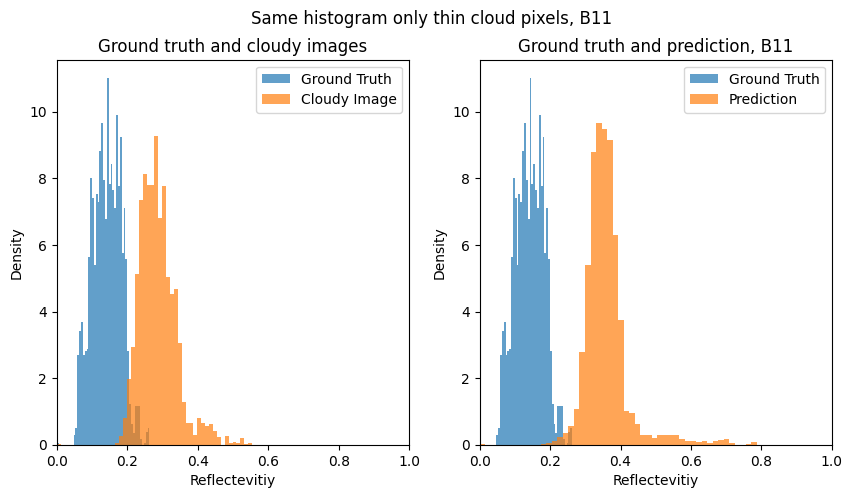

In [131]:
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0]

plt.rcParams['figure.figsize'] = [10, 5]
axs[0].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].hist(cloud_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].set_xlim([0,1])
axs[0].legend(['Ground Truth','Cloudy Image'])
axs[0].set_xlabel('Reflectevitiy')
axs[0].set_ylabel('Density')
axs[0].set_title('Ground truth and cloudy images')

axs[1].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].hist(pred_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].set_xlim([0,1])
axs[1].legend(['Ground Truth','Prediction'])
axs[1].set_xlabel('Reflectevitiy')
axs[1].set_ylabel('Density')
axs[1].set_title('Ground truth and prediction, B11')

fig.suptitle('Same histogram only thin cloud pixels, B11')

In [132]:
clear_array_c=np.zeros((1,12))
pred_array_c=np.zeros((1,12))
cloud_array_c=np.zeros((1,12))
cots=np.zeros(1)
p_c=0
percent=0.2
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]

    im_shape=np.shape(im_pred)

    cloud_mask=im_cloud[:,:,-1]
    cloud_mask_r=np.reshape(cloud_mask,im_shape[0]*im_shape[1])
    cloud_mask_r=cloud_mask_r==2

    im_pred_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    im_clear_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    for i in range(im_shape[2]):
        im_pred_r[:,i]=np.reshape(im_pred[:,:,i],im_shape[0]*im_shape[1])
        im_clear_r[:,i]=np.reshape(im_clear[:,:,i],im_shape[0]*im_shape[1])
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    im_pred_r=im_pred_r[cloud_mask_r,:]
    im_clear_r=im_clear_r[cloud_mask_r,:]
    im_cloud_r=im_cloud_r[cloud_mask_r,:]


    clear_array_c=np.concatenate((clear_array_c,im_clear_r[:,0:12]))
    pred_array_c=np.concatenate((pred_array_c,im_pred_r))
    cloud_array_c=np.concatenate((cloud_array_c,im_cloud_r))
    cots=np.concatenate((cots,np.reshape(im_cloud[:,:,12],im_shape[0]*im_shape[1])))

    p_c+=1

In [133]:
cots

array([ 0.        , 36.49323455, 36.49323455, ..., 28.86738853,
       28.86738853, 28.86738853])

Text(0.5, 0.98, 'Same histogram only thick cloud pixels, B11')

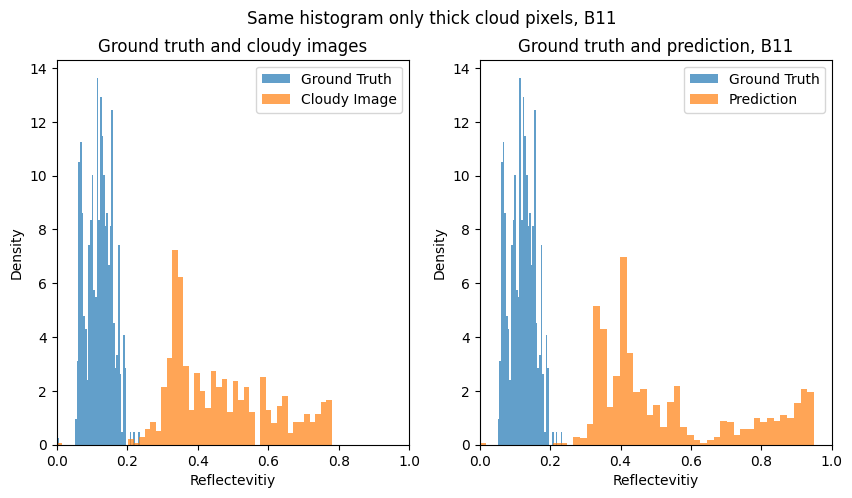

In [134]:
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0]

plt.rcParams['figure.figsize'] = [10, 5]
axs[0].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].hist(cloud_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].set_xlim([0,1])
axs[0].legend(['Ground Truth','Cloudy Image'])
axs[0].set_xlabel('Reflectevitiy')
axs[0].set_ylabel('Density')
axs[0].set_title('Ground truth and cloudy images')

axs[1].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].hist(pred_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].set_xlim([0,1])
axs[1].legend(['Ground Truth','Prediction'])
axs[1].set_xlabel('Reflectevitiy')
axs[1].set_ylabel('Density')
axs[1].set_title('Ground truth and prediction, B11')

fig.suptitle('Same histogram only thick cloud pixels, B11')

In [135]:
res=clear_array-pred_array

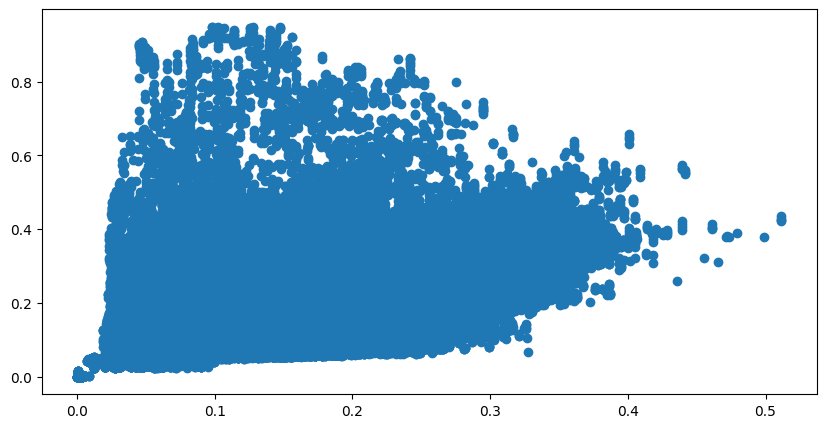

In [136]:
plt.scatter(clear_array,pred_array)

In [137]:
band=10
## Prediction v Ground Truth ##
y_true_11=clear_array[:,band]
pred_y_11=pred_array[:,band]
bins=np.linspace(0,0.6,10)

freq_true=np.zeros(len(bins))
freq_pred=np.zeros(len(bins))

freq_true_zero=np.zeros(len(bins))
freq_pred_zero=np.zeros(len(bins))

freq_true_thin=np.zeros(len(bins))
freq_pred_thin=np.zeros(len(bins))

freq_true_med=np.zeros(len(bins))
freq_pred_med=np.zeros(len(bins))

clear_true=clear_array[cloud_mask_array==0,:]
thin_true=clear_array[cloud_mask_array==1,:]
semi_true=clear_array[cloud_mask_array==2,:]

y_tmp_zero=clear_true[:,band]
y_tmp_thin=thin_true[:,band]
y_tmp_med=semi_true[:,band]

clear_pred=pred_array[cloud_mask_array==0,:]
thin_pred=pred_array[cloud_mask_array==1,:]
semi_pred=pred_array[cloud_mask_array==2,:]

y_tmp_pred_zero=clear_pred[:,band]
y_tmp_pred_thin=thin_pred[:,band]
y_tmp_pred_med=semi_pred[:,band]

for j,edge in enumerate(bins):
    if j!=0:
        indices=(y_true_11>bins[j-1])&(y_true_11<=edge)
        ind_z=(y_tmp_zero>bins[j-1])&(y_tmp_zero<=edge)
        ind_t=(y_tmp_thin>bins[j-1])&(y_tmp_thin<=edge)
        ind_m=(y_tmp_med>bins[j-1])&(y_tmp_med<=edge)

        mean_bin_true=np.mean(y_true_11[indices])
        mean_bin_pred=np.mean(pred_y_11[indices])

        mean_bin_true_zero=np.mean(y_tmp_zero[ind_z])
        mean_bin_pred_zero=np.mean(y_tmp_pred_zero[ind_z])

        mean_bin_true_thin=np.mean(y_tmp_thin[ind_t])
        mean_bin_pred_thin=np.mean(y_tmp_pred_thin[ind_t])

        mean_bin_true_med=np.mean(y_tmp_med[ind_m])
        mean_bin_pred_med=np.mean(y_tmp_pred_med[ind_m])
        
        freq_true[j]=mean_bin_true
        freq_pred[j]=mean_bin_pred


        freq_true_zero[j]=mean_bin_true_zero
        freq_pred_zero[j]=mean_bin_pred_zero


        freq_true_thin[j]=mean_bin_true_thin
        freq_pred_thin[j]=mean_bin_pred_thin


        freq_true_med[j]=mean_bin_true_med
        freq_pred_med[j]=mean_bin_pred_med



/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Ground truth over prediction, Real data')

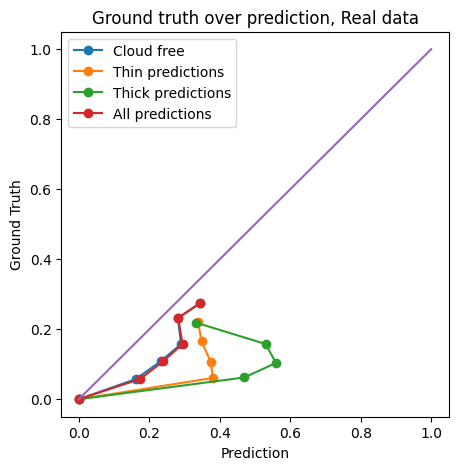

In [138]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.plot(freq_pred_zero,freq_true_zero,'-o')
plt.plot(freq_pred_thin,freq_true_thin,'-o')
plt.plot(freq_pred_med,freq_true_med,'-o')
plt.plot(freq_pred,freq_true,'-o')

#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
plt.plot(line,line)

plt.legend(['Cloud free','Thin predictions','Thick predictions','All predictions'])
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.title("Ground truth over prediction, Real data")

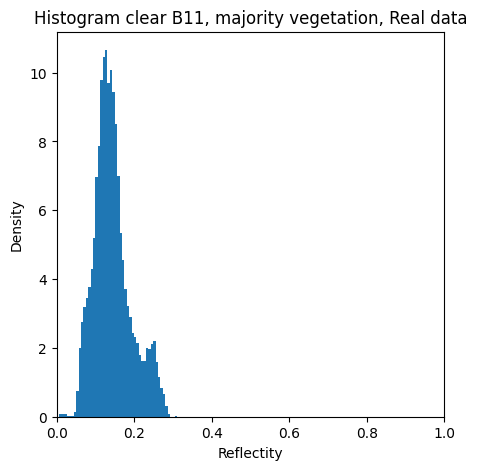

In [139]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.hist(clear_array[:,10],bins=50,density=True)
plt.xlim([0,1])
plt.title('Histogram clear B11, majority vegetation, Real data')
plt.xlabel('Reflectity')
plt.ylabel('Density')
plt.show()

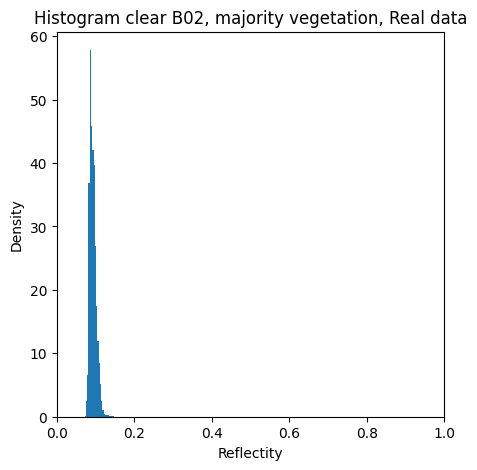

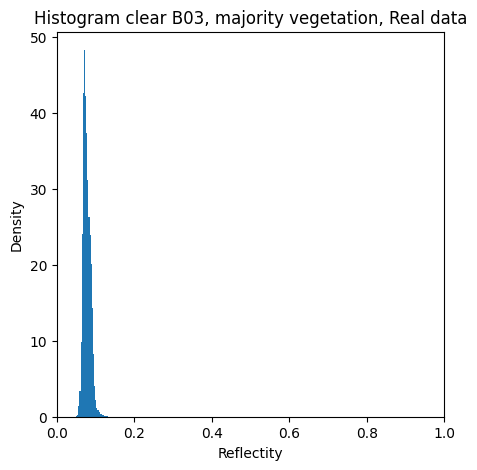

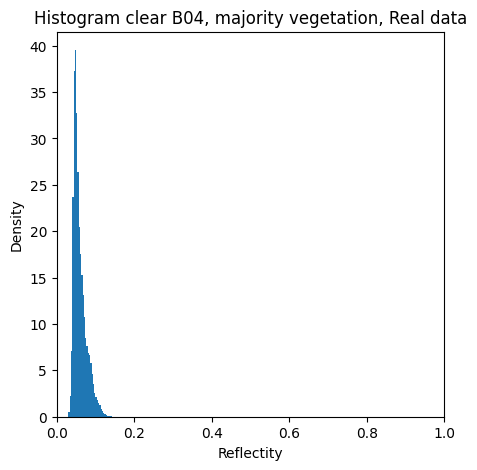

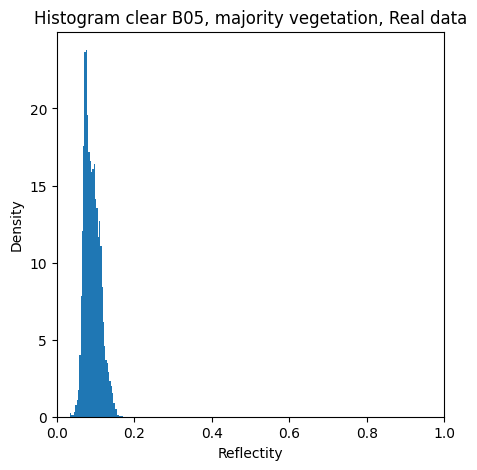

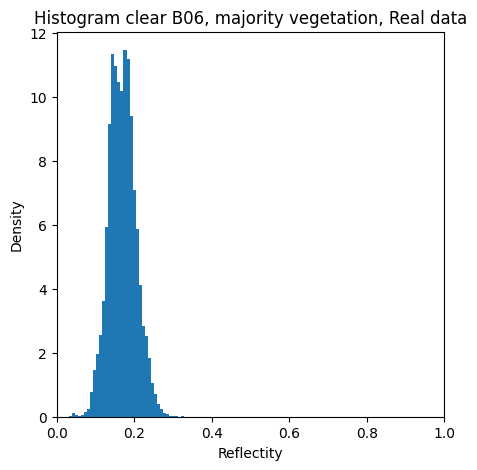

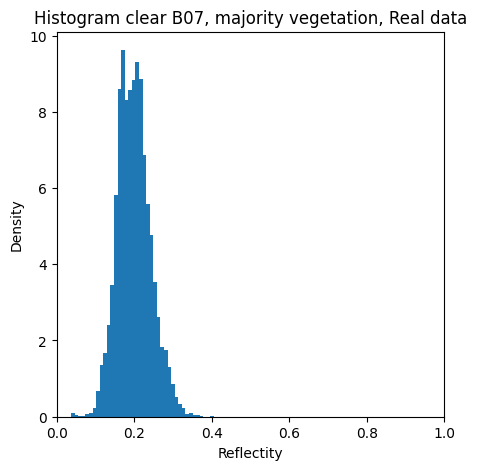

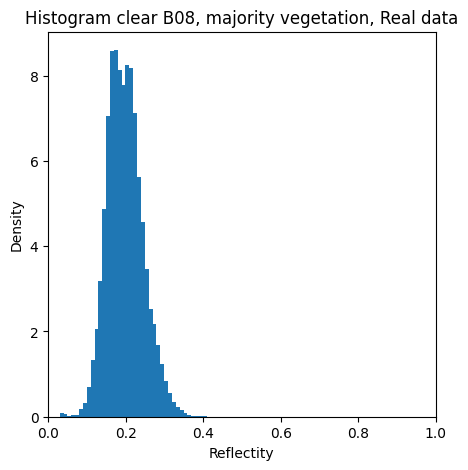

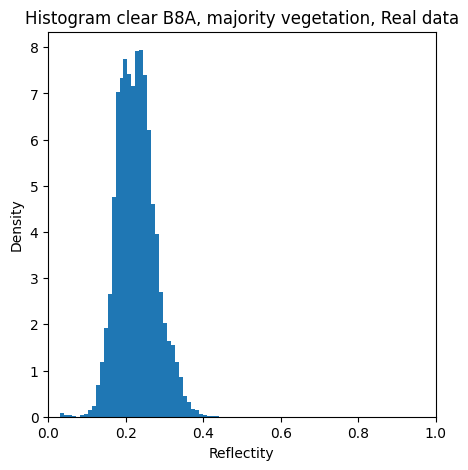

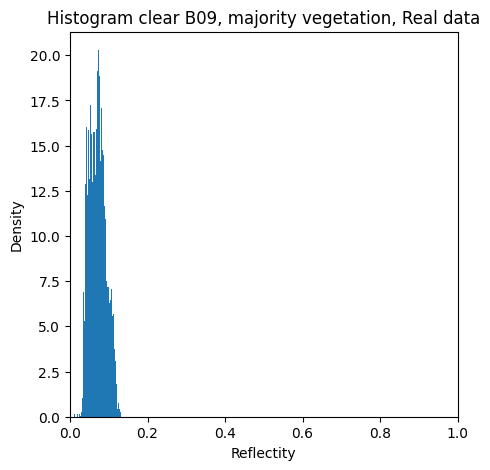

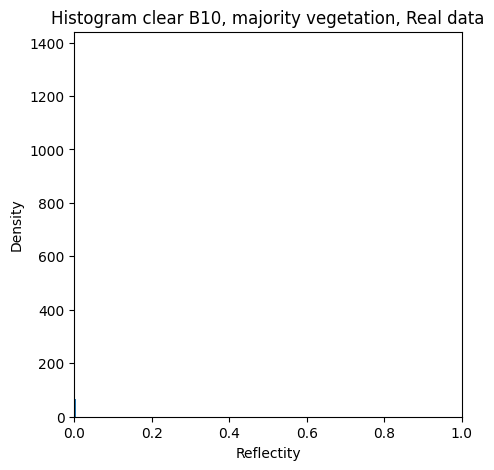

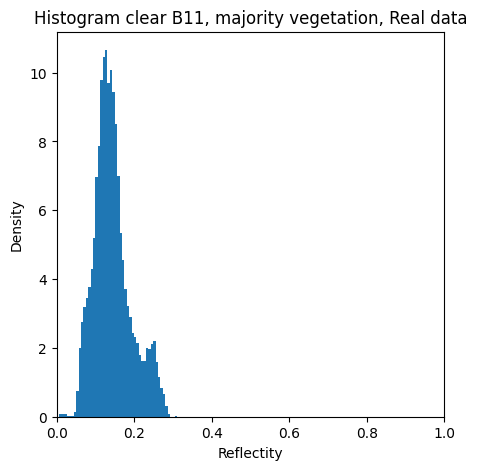

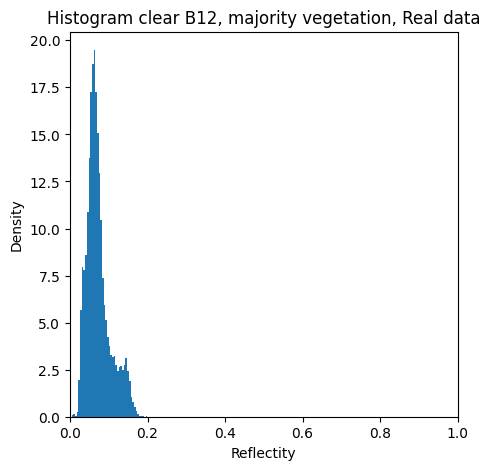

In [140]:
plt.rcParams["figure.figsize"] = [5, 5]
for band in range(0,12):

    plt.hist(clear_array[:,band],bins=50,density=True)
    plt.xlim([0,1])
    if band<7: 
        plt.title('Histogram clear B0'+str(band+2)+', majority vegetation, Real data')
    elif band==7:
        plt.title('Histogram clear B8A, majority vegetation, Real data')
    elif band==8:
        plt.title('Histogram clear B09, majority vegetation, Real data')
    else:
        plt.title('Histogram clear B'+str(band+1)+', majority vegetation, Real data')
    plt.xlabel('Reflectity')
    plt.ylabel('Density')
    plt.show()

## Specific image

In [141]:
which_pair=0 #5, 12
im_cloud=ims_all[which_pair][1]
im_clear=ims_all[which_pair][0]
im_pred=preds_all[which_pair]

In [142]:
## Setup for calculating RGB images

maxR = 3.0 ## max reflectance
midR = 0.13
sat = 1.3
gamma = 2.3
ray = { 'r': 0.013, 'g': 0.024, 'b': 0.041}



gOff = 0.01
gOffPow = gOff**gamma
gOffRange = (1 + gOff)**gamma - gOffPow


adjGamma = lambda b : ((b + gOff)**gamma - gOffPow)/gOffRange


def adj(a,tx,ty,maxC):
    ar = a/maxC
    ar[ar>1]=1
    ar[ar<0]=0
    return ar*(ar*(tx/maxC + ty - 1)- ty)/(ar*(2*tx/maxC - 1) - tx / maxC)

def satEnh(r,g,b):
    avgS = (r + g + b) / 3.0 * (1 - sat)
    tmpr=avgS + r * sat
    tmpr[tmpr>1]=1
    tmpr[tmpr<0]=0
    tmpg=avgS + g * sat
    tmpg[tmpg>1]=1
    tmpg[tmpg<0]=0
    tmpb=avgS + b * sat
    tmpb[tmpb>1]=1
    tmpb[tmpb<0]=0
    return [tmpr, tmpg, tmpb]


sAdj = lambda a: adjGamma(adj(a, midR, 1, maxR))
sRGB = lambda c: (12.92 * c) if c<= 0.0031308 else (1.055 * c**0.41666666666 - 0.055)

In [143]:
## Get "True" RGB Clear##
b04Tp=sAdj(im_clear[:,:,2]-ray['r'])
b03Tp=sAdj(im_clear[:,:,1]-ray['g'])
b02Tp=sAdj(im_clear[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_clear_show=np.zeros(np.shape(im_clear[:,:,0:3]))
im_clear_show[:,:,0]=rgbLin[0]
im_clear_show[:,:,1]=rgbLin[1]
im_clear_show[:,:,2]=rgbLin[2]

## Get "True" RGB Cloudy##
b04Tp=sAdj(im_cloud[:,:,2]-ray['r'])
b03Tp=sAdj(im_cloud[:,:,1]-ray['g'])
b02Tp=sAdj(im_cloud[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_cloud_show=np.zeros(np.shape(im_cloud[:,:,0:3]))
im_cloud_show[:,:,0]=rgbLin[0]
im_cloud_show[:,:,1]=rgbLin[1]
im_cloud_show[:,:,2]=rgbLin[2]


## Get "True" RGB prediction##
b04Tp=sAdj(im_pred[:,:,2]-ray['r'])
b03Tp=sAdj(im_pred[:,:,1]-ray['g'])
b02Tp=sAdj(im_pred[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_pred_show=np.zeros(np.shape(im_pred[:,:,0:3]))
im_pred_show[:,:,0]=rgbLin[0]
im_pred_show[:,:,1]=rgbLin[1]
im_pred_show[:,:,2]=rgbLin[2]

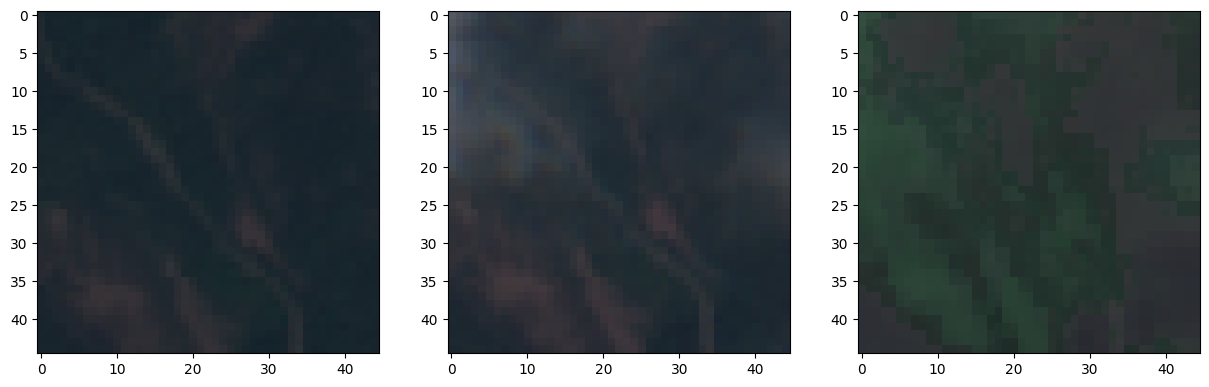

In [144]:
plt.rcParams["figure.figsize"] = [15, 5]
fig,axs=plt.subplots(ncols=3,nrows=1)
axs[0].imshow(np.flip(im_clear[:,:,0:3],axis=2)*2)
axs[1].imshow(np.flip(im_cloud[:,:,0:3],axis=2)*2)
axs[2].imshow(np.flip(im_pred[:,:,0:3],axis=2)*2)

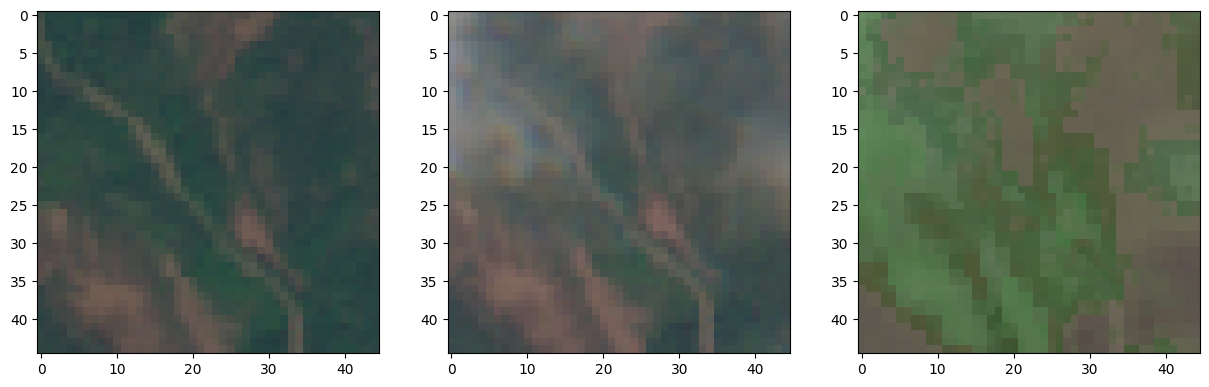

In [145]:
fig,axs=plt.subplots(ncols=3,nrows=1)
axs[0].imshow(im_clear_show[:,:,0:3])
axs[1].imshow(im_cloud_show[:,:,0:3])
axs[2].imshow(im_pred_show[:,:,0:3])

## Test feeding the algorithm a clear image

In [146]:
which_pair=0 #5, 12

im_cloud=ims_all[which_pair][1]
im_clear=ims_all[which_pair][0]
im_pred=preds_all[which_pair]


In [147]:
## Get "True" RGB Clear##
b04Tp=sAdj(im_clear[:,:,2]-ray['r'])
b03Tp=sAdj(im_clear[:,:,1]-ray['g'])
b02Tp=sAdj(im_clear[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_clear_show=np.zeros(np.shape(im_clear[:,:,0:3]))
im_clear_show[:,:,0]=rgbLin[0]
im_clear_show[:,:,1]=rgbLin[1]
im_clear_show[:,:,2]=rgbLin[2]

## Get "True" RGB Cloudy##
b04Tp=sAdj(im_cloud[:,:,2]-ray['r'])
b03Tp=sAdj(im_cloud[:,:,1]-ray['g'])
b02Tp=sAdj(im_cloud[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_cloud_show=np.zeros(np.shape(im_cloud[:,:,0:3]))
im_cloud_show[:,:,0]=rgbLin[0]
im_cloud_show[:,:,1]=rgbLin[1]
im_cloud_show[:,:,2]=rgbLin[2]


## Get "True" RGB prediction##
b04Tp=sAdj(im_pred[:,:,2]-ray['r'])
b03Tp=sAdj(im_pred[:,:,1]-ray['g'])
b02Tp=sAdj(im_pred[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_pred_show=np.zeros(np.shape(im_pred[:,:,0:3]))
im_pred_show[:,:,0]=rgbLin[0]
im_pred_show[:,:,1]=rgbLin[1]
im_pred_show[:,:,2]=rgbLin[2]

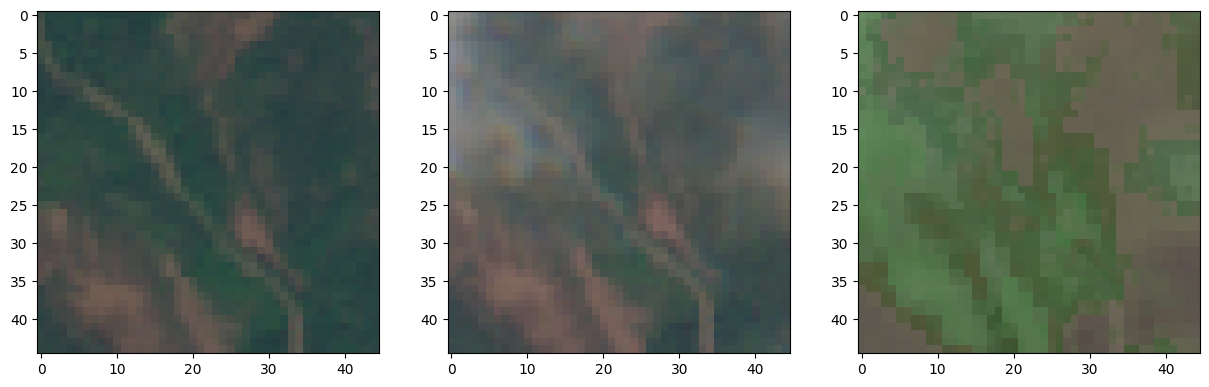

In [148]:
plt.rcParams["figure.figsize"] = [15, 5]
fig,axs=plt.subplots(ncols=3,nrows=1)
axs[0].imshow(im_clear_show[:,:,0:3])
axs[1].imshow(im_cloud_show[:,:,0:3])
axs[2].imshow(im_pred_show[:,:,0:3])

In [149]:
## Reshape cloudy data
im=im_clear
im_shape=np.shape(im)
im_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
for i in range(im_shape[2]):
    im_r[:,i]=np.reshape(im[:,:,i],im_shape[0]*im_shape[1])

    for i,model in enumerate(models):
        if i==0:
            pred=model.predict(im_r)
        else:   
            pred=pred+model.predict(im_r)
    pred=pred/len(models)
##Reshape back
im_shape_pred=(im_shape[0],im_shape[1],12)
im_pred=np.zeros(im_shape_pred)
im_unc=np.zeros(im_shape_pred)
for i in range(im_shape_pred[2]):
    im_pred[:,:,i]=np.reshape(pred[:,i,index_median],im_shape_pred[0:2])
    im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape_pred[0:2])

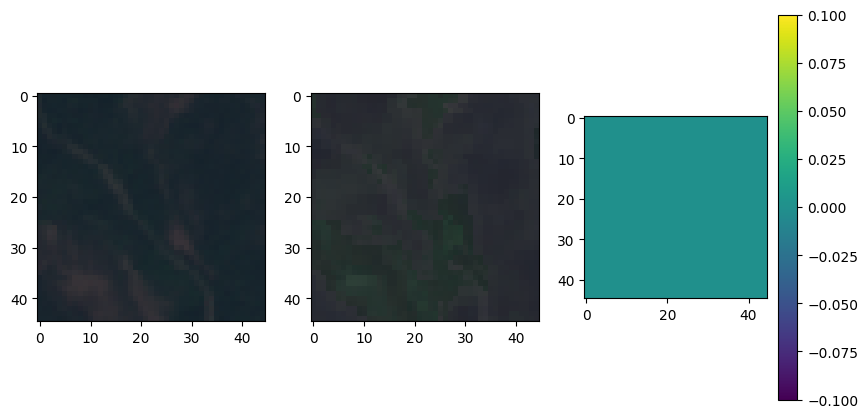

In [150]:
plt.rcParams["figure.figsize"] = [10, 5]
fig,axs=plt.subplots(nrows=1,ncols=3)
axs[0].imshow(np.flip(im[:,:,0:3],axis=2)*2)
axs[1].imshow(np.flip(im_pred[:,:,0:3],axis=2)*2)
i=axs[2].imshow(im[:,:,-1])
fig.colorbar(i,ax=axs[2])

In [151]:

#np.linal.norm() -> Frobenius norm i.e root of the sum of squares
norm_og=np.linalg.norm(np.square((im[:,:,0:12])-(im[:,:,0:12])),axis=(0,1))**2
norm_pred=np.linalg.norm(np.square((im[:,:,0:12])-im_pred[:,:,0:12]),axis=(0,1))**2
norm_gt=np.linalg.norm(np.square(im[:,:,0:12]),axis=(0,1))**2

NMSE_og=norm_og/norm_gt
NMSE_pred=norm_pred/norm_gt

NMSE_og_wo_10=np.concatenate((NMSE_og[0:9],NMSE_og[10:]),axis=0)
NMSE_pred_wo_10=np.concatenate((NMSE_pred[0:9],NMSE_pred[10:]),axis=0)

In [152]:
for i in range(len(NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(NMSE_pred[i]))    

    print(' ')
print('Mean NMSE before correction: '+str(np.mean(NMSE_og)))
print('Mean NMSE after correction: '+str(np.mean(NMSE_pred))) 

print(' ')
print('Mean NMSE before correction, without band 10: '+str(np.mean(NMSE_og_wo_10)))
print('Mean NMSE after correction, without band 10: '+str(np.mean(NMSE_pred_wo_10)))   

NMSE before correction, Band 2: 0.0
NMSE after correction, Band 2: 0.0001921804864113068
 
NMSE before correction, Band 3: 0.0
NMSE after correction, Band 3: 0.0015234994514340258
 
NMSE before correction, Band 4: 0.0
NMSE after correction, Band 4: 0.04755907025366656
 
NMSE before correction, Band 5: 0.0
NMSE after correction, Band 5: 0.009146293586250293
 
NMSE before correction, Band 6: 0.0
NMSE after correction, Band 6: 0.0005833178751919577
 
NMSE before correction, Band 7: 0.0
NMSE after correction, Band 7: 0.000349741807557841
 
NMSE before correction, Band 8: 0.0
NMSE after correction, Band 8: 0.00012991145798701813
 
NMSE before correction, Band 8A: 0.0
NMSE after correction, Band 8A: 6.566222369581852e-05
 
NMSE before correction, Band 9: 0.0
NMSE after correction, Band 9: 0.00011201016915754769
 
NMSE before correction, Band 10: 0.0
NMSE after correction, Band 10: 0.005445920703084725
 
NMSE before correction, Band 11: 0.0
NMSE after correction, Band 11: 0.4701686529346684
 

## Spectrum plots

In [153]:
which_pair=16 #5, 12

im_cloud=ims_all[which_pair][1]
im_clear=ims_all[which_pair][0]
im_pred=preds_all[which_pair]

In [154]:
## Get "True" RGB Clear##
b04Tp=sAdj(im_clear[:,:,2]-ray['r'])
b03Tp=sAdj(im_clear[:,:,1]-ray['g'])
b02Tp=sAdj(im_clear[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_clear_show=np.zeros(np.shape(im_clear[:,:,0:3]))
im_clear_show[:,:,0]=rgbLin[0]
im_clear_show[:,:,1]=rgbLin[1]
im_clear_show[:,:,2]=rgbLin[2]

## Get "True" RGB Cloudy##
b04Tp=sAdj(im_cloud[:,:,2]-ray['r'])
b03Tp=sAdj(im_cloud[:,:,1]-ray['g'])
b02Tp=sAdj(im_cloud[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_cloud_show=np.zeros(np.shape(im_cloud[:,:,0:3]))
im_cloud_show[:,:,0]=rgbLin[0]
im_cloud_show[:,:,1]=rgbLin[1]
im_cloud_show[:,:,2]=rgbLin[2]


## Get "True" RGB prediction##
b04Tp=sAdj(im_pred[:,:,2]-ray['r'])
b03Tp=sAdj(im_pred[:,:,1]-ray['g'])
b02Tp=sAdj(im_pred[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_pred_show=np.zeros(np.shape(im_pred[:,:,0:3]))
im_pred_show[:,:,0]=rgbLin[0]
im_pred_show[:,:,1]=rgbLin[1]
im_pred_show[:,:,2]=rgbLin[2]

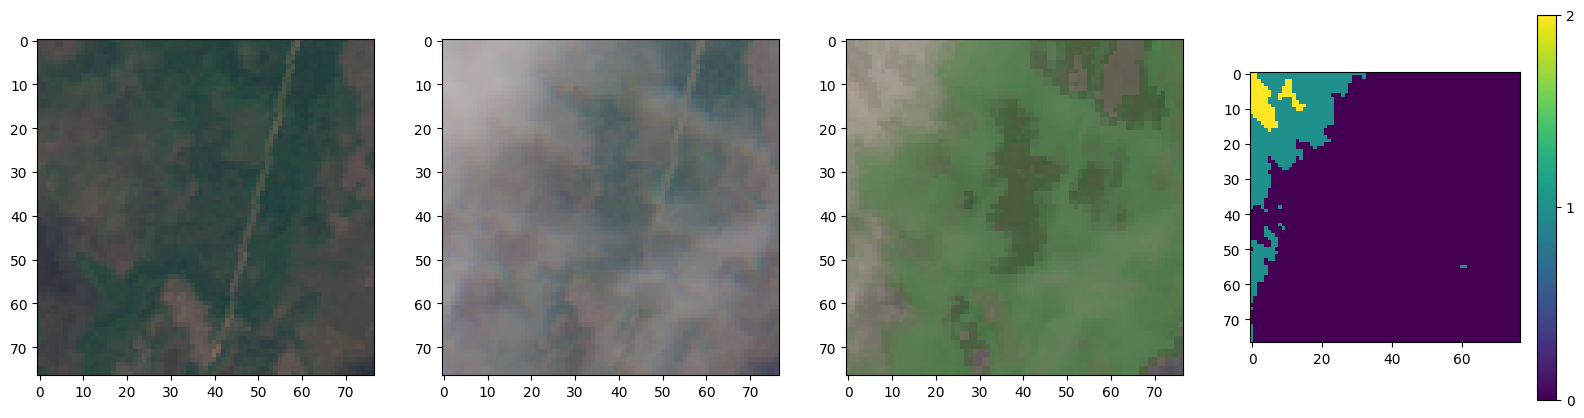

In [155]:
plt.rcParams["figure.figsize"] = [20, 5]
fig,axs=plt.subplots(ncols=4,nrows=1)
axs[0].imshow(im_clear_show[:,:,0:3])
axs[1].imshow(im_cloud_show[:,:,0:3])
axs[2].imshow(im_pred_show[:,:,0:3])
i=axs[3].imshow(im_cloud[:,:,-1])
fig.colorbar(i,ax=axs[3],ticks=[0,1,2])

In [156]:
pixel=(40,35)
pixel_clear=im_clear[pixel[0],pixel[1],:]
pixel_cloud=im_cloud[pixel[0],pixel[1],:]
pixel_pred=im_pred[pixel[0],pixel[1],:]

In [157]:
channels=['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12']

In [158]:
print("COT classification: "+str(pixel_cloud[-1]))

COT classification: 0.0


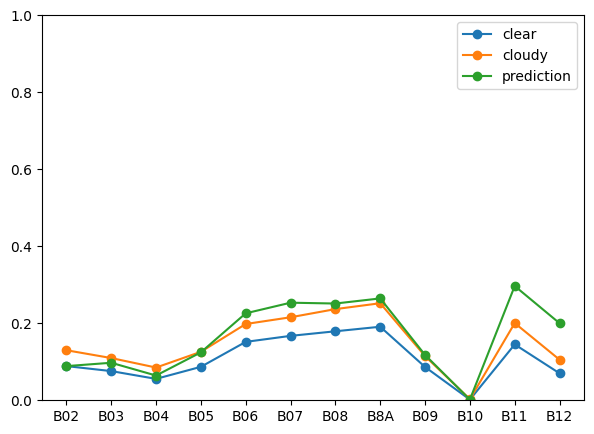

In [159]:
plt.rcParams["figure.figsize"] = [7, 5]
plt.plot(channels,pixel_clear[0:12],'-o')
plt.plot(channels,pixel_cloud[0:12],'-o')
plt.plot(channels,pixel_pred,'-o')
plt.ylim([0,1])
plt.legend(['clear','cloudy','prediction'])
plt.show()